In [463]:
######## MODULES ##########
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import celia_functions as cf
plt.rcParams.update({'font.size':14, "xtick.direction":"in", "ytick.direction":"in"})
pd.set_option('display.max_rows', 50)
#np.set_printoptions(threshold=sys.maxsize)

pyro_channels = ["Ch1","Ch2","Ch3","Ch4"] # Establishing a catagory of diagnostics will be helpful later.

In [464]:
shotsheet = cf.read_metadata(["SHOT #","Target X","Target Z","TARGET NUMBER","Laser Energy (before comp) [J]"])
targetsheet = cf.read_metadata(["Number","Wheel","Thickness (um)","Length(mm)","Material","Type"])

shotsheet = pd.DataFrame(shotsheet)
targetsheet = pd.DataFrame(targetsheet)

to_numeric = lambda series: pd.to_numeric(series, errors= "coerce") # pd.to_numeric works on pd.series but not on pd.DataFrames
shotsheet = shotsheet.apply(to_numeric) 
shotsheet.dropna(how= "all", inplace= True) # last row has no data! Remove it.

shotsheet = shotsheet.merge(targetsheet, how= "left", left_on= "TARGET NUMBER", right_on= "Number") # merge the targetsheet with the shotsheet

shotsheet.describe()

,SHOT #,Target X,Target Z,TARGET NUMBER,Laser Energy (before comp) [J],Number,Wheel,Thickness (um),Length(mm)
count,266.000000,234.000000,234.000000,266.000000,201.000000,266.000000,266.000000,266.000000,266.000000
mean,132.661654,3.552863,6.181303,68.000000,0.884909,68.000000,4.409774,264.097744,8.300752
std,76.697139,1.382375,0.950730,37.500893,0.173772,37.500893,1.806001,397.911451,1.228498
min,1.000000,0.705000,3.195000,1.000000,0.091800,1.000000,1.000000,25.000000,4.000000
25%,66.250000,2.475000,5.590000,33.750000,0.827000,33.750000,3.000000,50.000000,8.000000
50%,132.500000,3.395000,6.170000,69.000000,0.873000,69.000000,4.000000,50.000000,8.000000
75%,198.750000,4.511250,6.790000,104.750000,0.953000,104.750000,6.000000,50.000000,8.000000
max,265.000000,6.985000,8.815000,125.000000,1.800000,125.000000,7.000000,1000.000000,10.000000


In [465]:
shotsheet["relative X"] = shotsheet.groupby('Number')['Target X'].transform(lambda x: x -x.iloc[0]) #calculate the relitive movement from the first shot.
shotsheet["relative Z"] = shotsheet.groupby('Number')['Target Z'].transform(lambda x: x -x.iloc[0])
shotsheet["nth shot on target"] = shotsheet.groupby('Number')["Number"].transform(lambda series: np.arange(len(series)) +1) #add a column that counts how many times the target has been shot.

shotsheet["d"] = np.linalg.norm(shotsheet[["relative X", "relative Z"]], axis= 1) # pythagorus to find d. This might be a little simplistic since we know the angle should be 25°

# Apply filters
shotsheet = shotsheet[shotsheet["Type"] == "wire"]
shotsheet = shotsheet[shotsheet["Material"] == "Cu"]
shotsheet = shotsheet[shotsheet["Length(mm)"] == 8]

shotsheet.describe()

,SHOT #,Target X,Target Z,TARGET NUMBER,Laser Energy (before comp) [J],Number,Wheel,Thickness (um),Length(mm),relative X,relative Z,nth shot on target,d
count,158.000000,153.000000,153.000000,158.000000,150.000000,158.000000,158.000000,158.0,158.0,153.000000,153.000000,158.000000,153.000000
mean,151.860759,3.139706,5.933497,81.936709,0.859880,81.936709,4.974684,50.0,8.0,1.181111,0.696209,4.050633,1.397450
std,60.580574,1.041783,0.844642,25.858183,0.112956,25.858183,1.286626,0.0,0.0,0.983230,0.589355,2.793982,1.113761
min,34.000000,0.795000,3.195000,16.000000,0.414000,16.000000,2.000000,50.0,8.0,0.000000,0.000000,1.000000,0.000000
25%,101.250000,2.375000,5.400000,60.000000,0.809500,60.000000,4.000000,50.0,8.0,0.380000,0.220000,2.000000,0.466476
50%,140.500000,3.035000,5.960000,81.000000,0.862500,81.000000,5.000000,50.0,8.0,1.000000,0.610000,4.000000,1.337199
75%,199.750000,3.905000,6.470000,107.000000,0.933500,107.000000,6.000000,50.0,8.0,1.900000,1.115000,6.000000,2.263537
max,258.000000,5.495000,8.455000,116.000000,1.080000,116.000000,7.000000,50.0,8.0,3.500000,2.585000,15.000000,3.908657


### Choose which targets and channels to use here!

In [466]:
pyro_background = {"Ch1": [99,100,101,102,104,105,107,108,109,110,111,112,113,154,155,156,157,158,159,160,161,162,163,164,165,166,168,169,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,214,215,216,217,218,219,220,221,222,223,224,225,226,227,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265],
                   "Ch2": [114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140141,142,143,144,145,146,147,148,149,150,151,152,153],
                   "Ch3": [70,71,72,74,75,76,77,78,79,80,83,84,85,86,87,88,89,92,93,94,95,96,97,98]}

diagnostics = {"Ch1": shotsheet["SHOT #"],
               "Ch2": shotsheet["SHOT #"],
               "Ch3": shotsheet["SHOT #"],
               "Ch4": shotsheet["SHOT #"],
               "bdot": shotsheet["SHOT #"],
               "xray": shotsheet["SHOT #"],
               "energy": shotsheet["SHOT #"]}

diagnostics_functions = {"Ch1": lambda x: x,
                         "Ch2": lambda x: x,
                         "Ch3": lambda x: x,
                         "Ch4": lambda x: x,
                         "bdot": lambda x: np.ma.masked_invalid(x).ptp(),
                         "tof": np.ptp,
                         "diode": np.ptp,
                         "xray": cf.estimate_xray_signal,
                         "energy": lambda x: x}

diagnostic_data = cf.read_diagnostic_data(diagnostics, functions= diagnostics_functions, silent= False)
diagnostic_data = pd.DataFrame(diagnostic_data)

background_lookup = pd.DataFrame(([shot, ch, cf.flatten_list(diagnostic_data[ch][diagnostic_data["shot"] == shot].values)] for ch, shots in pyro_background.items() for shot in shots), columns= ["shot", "bg channel", "bg data"]) #Create a dataframe with the bg data


Found 149 files:
   260124WIRESHOT70000_Ch1.csv
   260124WIRESHOT70001_Ch1.csv
   260124WIRESHOT71000_Ch1.csv
   260124WIRESHOT72000_Ch1.csv
   260124WIRESHOT74000_Ch1.csv
   260124WIRESHOT75000_Ch1.csv
   290124WIRESHOT76000_Ch1.csv
   290124WIRESHOT77000_Ch1.csv
   290124WIRESHOT78000_Ch1.csv
   290124WIRESHOT79000_Ch1.csv
   290124WIRESHOT80000_Ch1.csv
   290124WIRESHOT81000_Ch1.csv
   290124WIRESHOT82000_Ch1.csv
   290124WIRESHOT83000_Ch1.csv
   290124WIRESHOT84000_Ch1.csv
   290124WIRESHOT85000_Ch1.csv
   290124WIRESHOT86000_Ch1.csv
   290124WIRESHOT87000_Ch1.csv
   290124WIRESHOT88000_Ch1.csv
   290124WIRESHOT89000_Ch1.csv
   290124WIRESHOT91000_Ch1.csv
   290124WIRESHOT92000_Ch1.csv
   290124WIRESHOT93000_Ch1.csv
   290124WIRESHOT94000_Ch1.csv
   290124WIRESHOT95000_Ch1.csv
   290124WIRESHOT96000_Ch1.csv
   290124WIRESHOT97000_Ch1.csv
   290124WIRESHOT98000_Ch1.csv
   290124WIRESHOT100000_Ch1.csv
   290124WIRESHOT101000_Ch1.csv
   290124WIRESHOT102000_Ch1.csv
   290124WIRESHOT10

In [467]:
active_pyro_channels = np.intersect1d(pyro_channels, list(diagnostic_data.keys())) # useful to know which pyro channels to analysise and plot

diagnostic_data = diagnostic_data.merge(background_lookup, how= "left", on= "shot") # add the background infomation to the shotsheet
diagnostic_data["bg data"].fillna(0, inplace= True) # Sometimes the background was not measured

diagnostic_data[active_pyro_channels] = (diagnostic_data[active_pyro_channels].values.T -diagnostic_data["bg data"].values).T # Background subtraction. It took me ages to figure out how to do this with pandas. (Spoilers: I cheated and converted it into numpy arrays)
diagnostic_data.drop("bg data", axis= 1, inplace= True) # The background data is no longer needed now that we have finished background subtraction.

diagnostic_data.describe()

C:\Users\syf83691\AppData\Local\Temp\ipykernel_25320\2145891751.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  diagnostic_data["bg data"].fillna(0, inplace= True) # Sometimes the background was not measured


,shot,bdot,xray,energy
count,156.000000,147.000000,126.000000,1.460000e+02
mean,153.096154,0.622653,753.988095,1.053210e-06
std,59.966526,0.193650,475.775647,4.735935e-07
min,34.000000,0.021836,2.000000,2.010000e-09
25%,102.750000,0.525398,298.500000,7.677500e-07
50%,141.500000,0.655547,814.000000,1.110000e-06
75%,200.250000,0.754352,1112.125000,1.387500e-06
max,258.000000,1.010719,1685.500000,2.080000e-06


In [468]:
find_minima = lambda x: np.abs(np.nanmin(x))
diagnostic_data[active_pyro_channels] = diagnostic_data[active_pyro_channels].map(find_minima, na_action= "ignore") # find the minima of every pyro channel. df.map applies the function element-wise rather than row or column-wise

shotsheet = shotsheet.merge(diagnostic_data, how= "left", left_on= "SHOT #", right_on= "shot") #merge with shotsheet

shotsheet.describe()

,SHOT #,Target X,Target Z,TARGET NUMBER,Laser Energy (before comp) [J],Number,Wheel,Thickness (um),Length(mm),relative X,...,nth shot on target,d,shot,Ch1,Ch2,Ch3,Ch4,bdot,xray,energy
count,158.000000,153.000000,153.000000,158.000000,150.000000,158.000000,158.000000,158.0,158.0,153.000000,...,158.000000,153.000000,156.000000,146.000000,151.000000,146.000000,146.000000,147.000000,126.000000,1.460000e+02
mean,151.860759,3.139706,5.933497,81.936709,0.859880,81.936709,4.974684,50.0,8.0,1.181111,...,4.050633,1.397450,153.096154,0.153753,0.733804,1.247425,0.861068,0.622653,753.988095,1.053210e-06
std,60.580574,1.041783,0.844642,25.858183,0.112956,25.858183,1.286626,0.0,0.0,0.983230,...,2.793982,1.113761,59.966526,0.298609,1.449065,1.664685,0.443873,0.193650,475.775647,4.735935e-07
min,34.000000,0.795000,3.195000,16.000000,0.414000,16.000000,2.000000,50.0,8.0,0.000000,...,1.000000,0.000000,34.000000,0.000000,0.000000,0.000000,0.016000,0.021836,2.000000,2.010000e-09
25%,101.250000,2.375000,5.400000,60.000000,0.809500,60.000000,4.000000,50.0,8.0,0.380000,...,2.000000,0.466476,102.750000,0.000000,0.001100,0.112000,0.561000,0.525398,298.500000,7.677500e-07
50%,140.500000,3.035000,5.960000,81.000000,0.862500,81.000000,5.000000,50.0,8.0,1.000000,...,4.000000,1.337199,141.500000,0.000000,0.192000,0.338000,0.856000,0.655547,814.000000,1.110000e-06
75%,199.750000,3.905000,6.470000,107.000000,0.933500,107.000000,6.000000,50.0,8.0,1.900000,...,6.000000,2.263537,200.250000,0.160000,0.520000,2.083000,1.088000,0.754352,1112.125000,1.387500e-06
max,258.000000,5.495000,8.455000,116.000000,1.080000,116.000000,7.000000,50.0,8.0,3.500000,...,15.000000,3.908657,258.000000,1.608000,7.792000,8.020000,2.108000,1.010719,1685.500000,2.080000e-06


In [469]:
diags = list(diagnostics)

shotsheet[diags] = (shotsheet[diags].values.T /shotsheet["Laser Energy (before comp) [J]"].values).T # normalise for laser energy
shotsheet[diags] = shotsheet.groupby('TARGET NUMBER')[diags].transform(lambda x: x /x.iloc[0]) # normalise to first shot on target
#shotsheet[diags] = shotsheet[diags] /shotsheet[diags].mean()
shotsheet = shotsheet.replace([-np.inf, np.inf], np.nan) # infs are invalid. I think there were some div 0 errors when normalising to the first shot on target.

shotsheet.describe()

,SHOT #,Target X,Target Z,TARGET NUMBER,Laser Energy (before comp) [J],Number,Wheel,Thickness (um),Length(mm),relative X,...,nth shot on target,d,shot,Ch1,Ch2,Ch3,Ch4,bdot,xray,energy
count,158.000000,153.000000,153.000000,158.000000,150.000000,158.000000,158.000000,158.0,158.0,153.000000,...,158.000000,153.000000,156.000000,67.000000,106.000000,127.000000,146.000000,124.000000,126.000000,124.000000
mean,151.860759,3.139706,5.933497,81.936709,0.859880,81.936709,4.974684,50.0,8.0,1.181111,...,4.050633,1.397450,153.096154,1.331045,1.066504,0.742426,2.828257,0.986941,1.358069,0.967889
std,60.580574,1.041783,0.844642,25.858183,0.112956,25.858183,1.286626,0.0,0.0,0.983230,...,2.793982,1.113761,59.966526,1.650555,1.070541,0.423684,9.420838,0.276274,0.913031,0.517765
min,34.000000,0.795000,3.195000,16.000000,0.414000,16.000000,2.000000,50.0,8.0,0.000000,...,1.000000,0.000000,34.000000,0.054121,0.002321,0.000000,0.056282,0.336193,0.007511,0.087512
25%,101.250000,2.375000,5.400000,60.000000,0.809500,60.000000,4.000000,50.0,8.0,0.380000,...,2.000000,0.466476,102.750000,0.270280,0.504020,0.387287,0.650813,0.847046,0.940105,0.666827
50%,140.500000,3.035000,5.960000,81.000000,0.862500,81.000000,5.000000,50.0,8.0,1.000000,...,4.000000,1.337199,141.500000,0.997940,0.805390,0.855193,0.989856,1.000000,1.059119,0.950743
75%,199.750000,3.905000,6.470000,107.000000,0.933500,107.000000,6.000000,50.0,8.0,1.900000,...,6.000000,2.263537,200.250000,1.441547,1.010886,1.000000,1.111796,1.059800,1.600609,1.067071
max,258.000000,5.495000,8.455000,116.000000,1.080000,116.000000,7.000000,50.0,8.0,3.500000,...,15.000000,3.908657,258.000000,9.615668,7.042607,2.172656,69.510526,1.964988,5.007349,3.289470


In [470]:
print(*zip(shotsheet[["xray", "nth shot on target"]].values), sep= "\n")

(array([nan,  1.]),)
(array([nan,  1.]),)
(array([nan,  1.]),)
(array([nan,  1.]),)
(array([nan,  1.]),)
(array([nan,  1.]),)
(array([nan,  2.]),)
(array([nan,  1.]),)
(array([1., 1.]),)
(array([2.26537363, 2.        ]),)
(array([2.99245283, 3.        ]),)
(array([0.02144605, 4.        ]),)
(array([2.11355371, 5.        ]),)
(array([1.07381789, 6.        ]),)
(array([1., 1.]),)
(array([1.48602899, 2.        ]),)
(array([0.62931649, 3.        ]),)
(array([1.3400371, 4.       ]),)
(array([0.54940838, 5.        ]),)
(array([0.03389831, 6.        ]),)
(array([0.10588598, 7.        ]),)
(array([3.39832517, 8.        ]),)
(array([3.81233432, 9.        ]),)
(array([ 2.37098374, 10.        ]),)
(array([ 0.41797097, 11.        ]),)
(array([ 5.00734912, 12.        ]),)
(array([ 0.48868095, 13.        ]),)
(array([ 3.86324721, 14.        ]),)
(array([ 0.12597683, 15.        ]),)
(array([1., 1.]),)
(array([1.25672212, 2.        ]),)
(array([1.12653299, 3.        ]),)
(array([1.01238695, 4.        

### Setup parameters for graph

In [471]:
### best fit parameters
number_of_points = 100 #number of points for the best fit line.
confidence= 0.05 #only used by polynomial_fit

x0 = {"Ch1": [1,1e5],
      "Ch2": [1,1e5],
      "Ch3": [1,1e5],
      "Ch4": [1,1e5],
      "bdot": [1,1e5],
      "energy": [1e-6,1],
      "xray": [0,1e6]}

constraints = {"Ch1": None, #[[lower], [upper]]
               "Ch2": None,
               "Ch3": None,
               "Ch4": None,
               "bdot": None, #scipy least_squares doesn't support equality constraints for some reason.
               "energy": None,
               "xray": None}

formatting = {"Ch1": {"colour": "aquamarine", "linestyle": "-", "marker": "^"},
              "Ch2": {"colour": "cyan", "linestyle": "-", "marker": ">"},
              "Ch3": {"colour": "dodgerblue", "linestyle": "-", "marker": "v"},
              "Ch4": {"colour": "blue", "linestyle": "-", "marker": "<"},
              "bdot": {"colour": "crimson", "linestyle": "-.", "marker": "s"},
              "energy": {"colour": "black", "linestyle": "--", "marker": "o"},
              "xray": {"colour": "darkgreen", "linestyle": ":", "marker": "x"}}

xaxis = "d"

model= cf.polynomial

In [495]:
x= shotsheet["d"]
x= x[~np.isnan(x)]
np.sort(x)[::len(x)//7]

array([0.        , 0.        , 0.51      , 1.02133491, 1.54777259,
       2.03409341, 2.60288782, 3.48093378])

In [514]:
scatter_points = pd.DataFrame(columns= [*diagnostics, "d"])
scatter_error = pd.DataFrame(columns= [*diagnostics, "d"])

#scatter_points = shotsheet.groupby('nth shot on target')[[*diagnostics, "d"]].mean()
#scatter_error = shotsheet.groupby('nth shot on target')[[*diagnostics, "d"]].std()

def binned_mean(y, x, function):
    means = []
    bins = np.linspace(x.min(), x.max(), 8, endpoint= True)
    for bin_min, bin_max in zip(bins[:-1], bins[1:]):
        mean = y[np.logical_and(bin_min <= x, x <= bin_max)]
        mean = function(mean)
        means = means + [mean]
    return means

scatter_points = shotsheet[[*diagnostics, "d"]].apply(binned_mean, x= shotsheet["d"], function= np.mean) # df.apply is very fussy. be careful which function to use with it.
scatter_error = shotsheet[[*diagnostics, "d"]].apply(binned_mean, x= shotsheet["d"], function= np.std)

scatter_points

,Ch1,Ch2,Ch3,Ch4,bdot,xray,energy,d
0,1.249216,0.962409,0.941522,1.009208,1.024620,1.149362,1.071538,0.104322
1,1.619202,1.115956,0.663236,3.321064,0.995627,1.398887,0.996497,0.821512
2,1.086507,0.906361,0.726287,2.258770,1.052471,1.371134,1.086086,1.413279
3,1.156311,1.217901,0.789540,3.741450,0.991263,1.698950,0.962796,1.954883
4,1.425908,1.040513,0.572935,3.876014,1.026287,1.382856,0.981894,2.522342
5,0.787383,0.858139,0.598285,0.791067,0.755651,1.350056,0.531669,3.051555
6,3.615492,1.696215,0.758601,9.273646,0.848485,1.641710,0.684091,3.579729


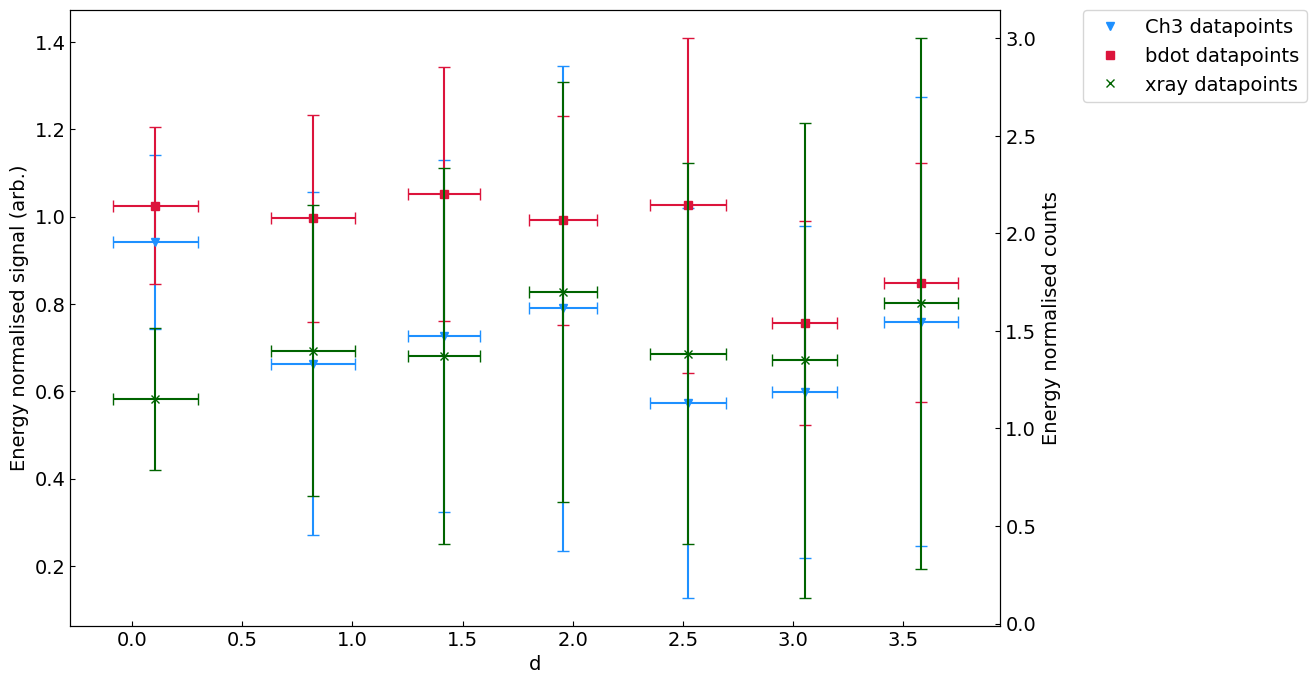

In [515]:
fig, axs = plt.subplots(1, 1, figsize= (12,8))
handles = {}

def plot_diagnostic(diagnostic, ax):
    ax.errorbar(scatter_points[xaxis],
                        scatter_points[diagnostic],
                        xerr= scatter_error[xaxis],
                        yerr= scatter_error[diagnostic],
                        color= formatting[diagnostic]["colour"],
                        linestyle= "None",
                        capsize= 4,
                        marker= formatting[diagnostic]["marker"],
                        label= "{0:} datapoints".format(diagnostic))

for diagnostic in ["Ch3","bdot"]:
    plot_diagnostic(diagnostic, axs)

twinax = axs.twinx() 
for diagnostic in ["xray"]:
    plot_diagnostic(diagnostic, twinax)

handles, labels = zip(axs.get_legend_handles_labels(), twinax.get_legend_handles_labels())

axs.set(xlabel= xaxis,
        ylabel= "Energy normalised signal (arb.)")
twinax.set(ylabel= "Energy normalised counts")

handles = cf.flatten_list(handles)[::7]
labels = cf.flatten_list(labels)
axs.legend(handles, labels, loc= "upper right", bbox_to_anchor= (1.34, 1.015)) # loc fixes the location of the legend. 

plt.show()

In [474]:
len(handles)

3